Evaluating the performace of Deep Learning for Next Word Prediction
---
* Deivanand E
* 21MDT1018
* M.Sc Data Science

 ## PRE REQUISITES

In [ ]:
import re
import pickle
import time
import json
import random
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('punkt')
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM, Activation, Dropout, Dense, Input,Embedding,Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model,Sequential,save_model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\deiva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
###  Reading the raw text data
text_corpus= open('corpus.txt',encoding="utf8").read()
print(len(text_corpus))

7540199


## EXPLORATORY DATA ANALYSIS

### Cleaning

- Removing Extra space
- Removing Special Characters
- Tokenizing text data

In [ ]:
def extra_space(text):
    new_text= re.sub("\s+"," ",text)
    return new_text
def sp_charac(text):
    new_text=re.sub("[^0-9A-Za-z ]", "" , text)
    return new_text
def tokenize_text(text):
    new_text=word_tokenize(text)
    return new_text

In [ ]:
cleaned_text=extra_space(text_corpus)
print("Removed Extra Spaces")

cleaned_text=sp_charac(cleaned_text)
print("Removed Special Caracters")

cleaned_text=tokenize_text(cleaned_text)
print("Tokenized data")

Removed Extra Spaces
Removed Special Caracters
Tokenized data


In [ ]:
# Storing them in separate text files
with open("cleaned_text.txt", "wb") as fp:   #Pickling
    pickle.dump(cleaned_text, fp)

In [ ]:
with open("cleaned_text.txt", "rb") as fp:   # Unpickling
    cleaned_corpus = pickle.load(fp)

In [ ]:
print(len(cleaned_corpus))

1107576


In [ ]:
print(cleaned_corpus[:500])

['In', 'science', 'and', 'engineering', 'intelligent', 'processing', 'of', 'complex', 'signals', 'such', 'as', 'images', 'sound', 'or', 'language', 'is', 'often', 'performed', 'by', 'a', 'parameterized', 'hierarchy', 'of', 'nonlinear', 'processing', 'layers', 'sometimes', 'biologically', 'inspired', 'Hierarchical', 'systems', 'or', 'more', 'generally', 'nested', 'systems', 'offer', 'a', 'way', 'to', 'generate', 'complex', 'mappings', 'using', 'simple', 'stages', 'Each', 'layer', 'performs', 'a', 'different', 'operation', 'and', 'achieves', 'an', 'ever', 'more', 'sophisticated', 'representation', 'of', 'the', 'input', 'as', 'for', 'example', 'in', 'an', 'deep', 'artificial', 'neural', 'network', 'an', 'object', 'recognition', 'cascade', 'in', 'computer', 'vision', 'or', 'a', 'speech', 'frontend', 'processing', 'Joint', 'estimation', 'of', 'the', 'parameters', 'of', 'all', 'the', 'layers', 'and', 'selection', 'of', 'an', 'optimal', 'architecture', 'is', 'widely', 'considered', 'to', 'be'

#### Creating dictionary of unigrams with stopwords

In [ ]:
word_count={}
for word in cleaned_corpus:
    if word not in word_count:
        word_count[word]=0
    word_count[word]+=1


In [ ]:
import numpy as np
np.save('unigram_dict.npy', word_count)

In [ ]:
freq_df  = pd.DataFrame.from_dict(word_count,orient='index',columns=['Count'])
freq_df=freq_df.sort_values(by=['Count'],ascending=False)
freq_df.head()

,Count
the,53568
of,39024
a,30888
to,28872
and,27144


#### Creating dictionary of unigrams without stopwords

In [ ]:
from wordcloud import WordCloud, STOPWORDS
counter={}
for i in word_count.keys():
    if i not in list(STOPWORDS):
        counter[i]=word_count[i]
print(len(counter.keys()))

2746


There are a total of 2746 unique words in the corpus excluding stopwords.

### Visualization

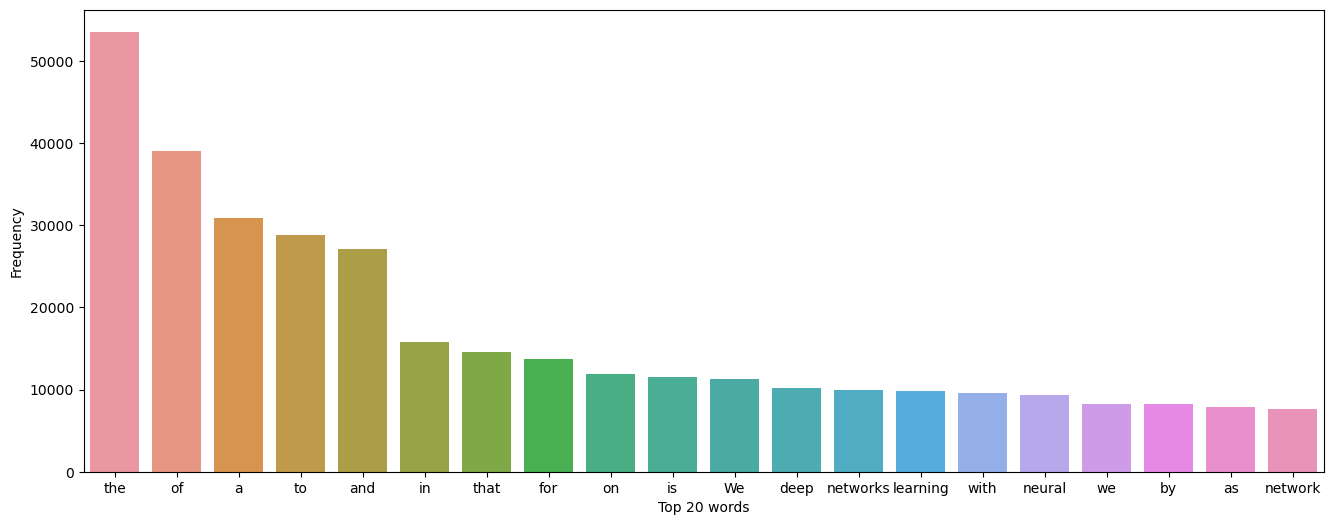

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
sns.barplot(x=freq_df.head(20).index,y=freq_df.head(20)['Count'])
plt.xlabel("Top 20 words")
plt.ylabel("Frequency")
plt.show()


- Visualising the top 50 words based on their frequency of occurrence
- Most of them are stopwords as they are used frequently .


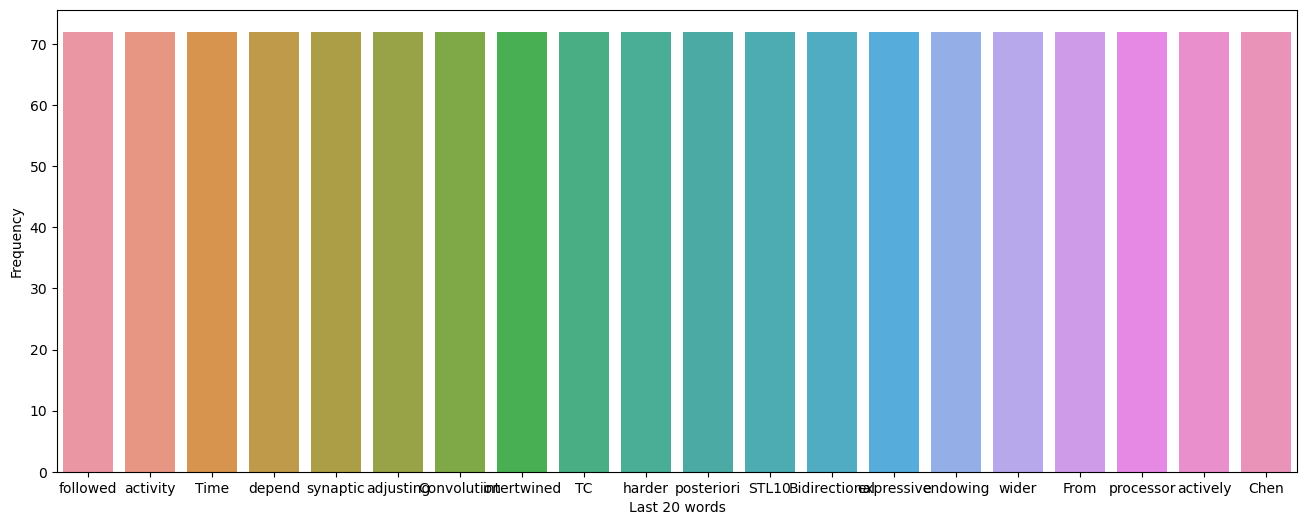

In [ ]:
plt.figure(figsize=(16,6))
sns.barplot(x=freq_df.tail(20).index,y=freq_df.tail(20)['Count'])
plt.xlabel("Last 20 words")
plt.ylabel("Frequency")
plt.show()

- Visualizing the last 50 words based on their frequency
- All of them occur once in the entire corpus

### WORD CLOUDS

#### UNIGRAM WORDCLOUD

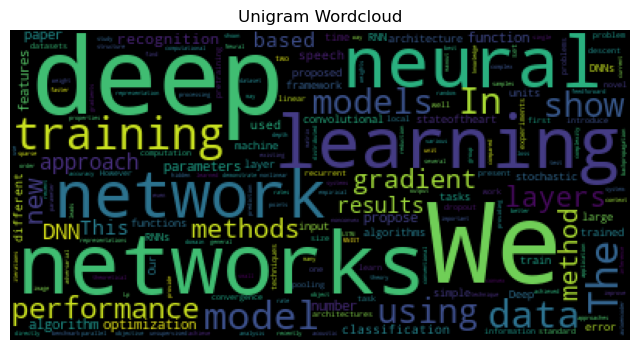

In [ ]:
wordcloud = WordCloud( background_color="black").generate_from_frequencies(counter)
plt.figure(figsize=(8, 5))
plt.axis("off")
plt.title("Unigram Wordcloud")
plt.imshow(wordcloud)

- Generated the word cloud with unigram words .
- There are no stopwords here as I am trying to visualize most commonly used non-stopwords.

##### Deleting the variable to save memory consumption

In [ ]:
del word_count

#### BIGRAM WORDCLOUD

In [ ]:
finder = BigramCollocationFinder.from_words(cleaned_corpus)
bigram_measures = BigramAssocMeasures()
scored = finder.score_ngrams(bigram_measures.raw_freq)

In [ ]:
#joining the two words with an _
bigram_dict={}
for i in range(len(scored)):
    bigram_dict['_'.join(scored[i][0])] = scored[i][1]

In [ ]:
np.save('bigram_dict.npy', bigram_dict)

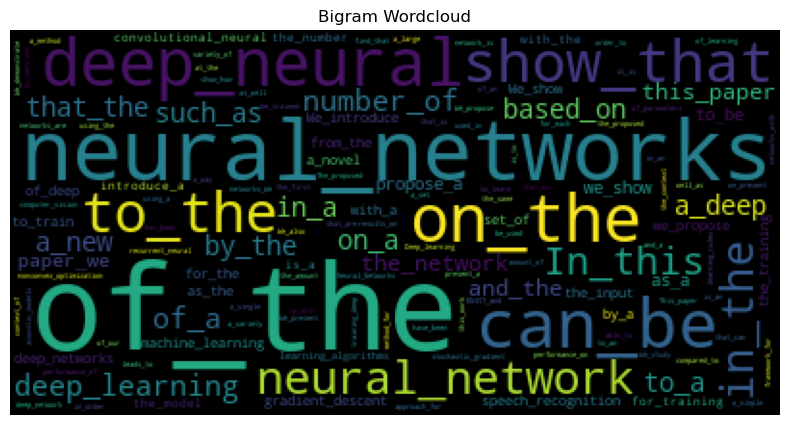

In [ ]:
wordcloud = WordCloud( background_color="black").generate_from_frequencies(bigram_dict)
plt.figure(figsize=(10, 5))
plt.axis("off")
plt.title("Bigram Wordcloud")
plt.imshow(wordcloud)
plt.show()

- Here I have included the stopwords otherwose the meaning of the phrases will change.
- There is a lot of preposition use as observed from the word cloud

In [ ]:
del bigram_dict

#### TRIGRAM WORDCLOUD

In [ ]:
data=" ".join(cleaned_corpus[:100000])

In [ ]:
vectorizer = CountVectorizer(ngram_range=(3,3),stop_words=None)
X = vectorizer.fit_transform([data])
vocab = vectorizer.vocabulary_
print("Vectorized the data : ")
count_values = X.toarray().sum(axis=0)
print("Creating Trigram Dictionary")
trigram_dict={}
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    trigram_dict[ng_text]=ng_count

Vectorized the data : 
Creating Trigram Dictionary


In [ ]:
np.save('trigram_dict.npy', trigram_dict)

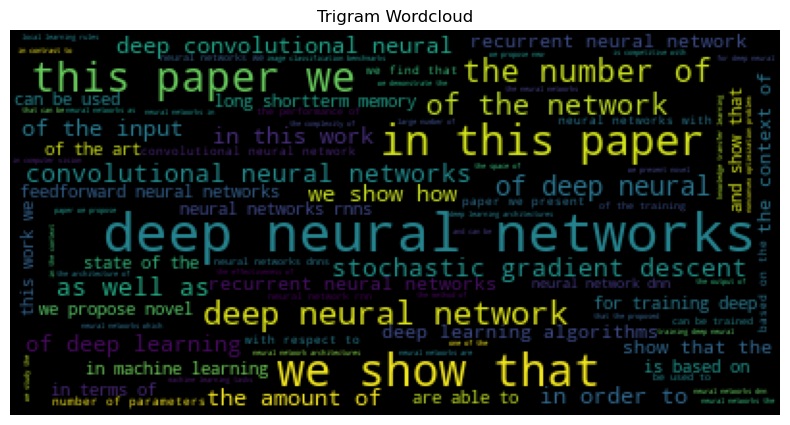

In [ ]:
wordcloud = WordCloud( background_color="black").generate_from_frequencies(trigram_dict)
plt.figure(figsize=(10, 5))
plt.axis("off")
plt.title("Trigram Wordcloud")
plt.imshow(wordcloud)
plt.show()

####  Most commonly used phrases
- 'deep neural networks'
- 'we show that'
- 'in this paper'
- 'stochastic gradient descent'
- 'of the network'


In [ ]:
del trigram_dict

#### QUADGRAM WORDCLOUD

In [ ]:
quad_data=" ".join(cleaned_corpus[:1000000])

In [ ]:
vectorizer = CountVectorizer(ngram_range=(4,4),stop_words=None)
X = vectorizer.fit_transform([quad_data])
vocab = vectorizer.vocabulary_
print("Vectorized the data : ")
count_values = X.toarray().sum(axis=0)
print("Creating Quadgram Dictionary")
quadgram_dict={}
for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
    quadgram_dict[ng_text]=ng_count

Vectorized the data : 
Creating Quadgram Dictionary


In [ ]:
np.save('quadgram_dict.npy', quadgram_dict)

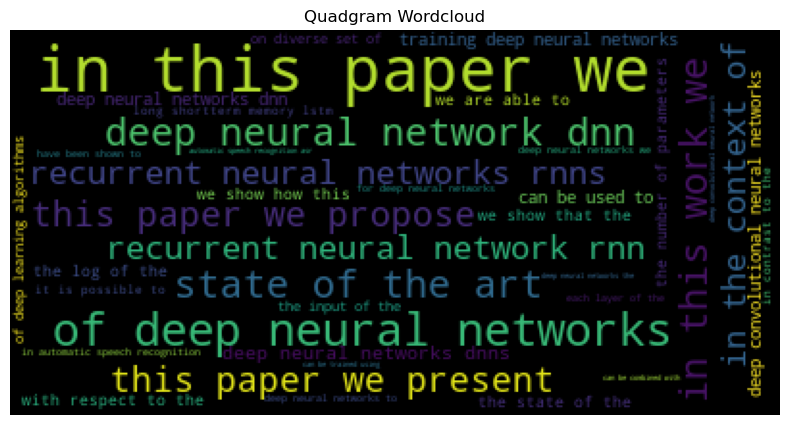

In [ ]:
wordcloud = WordCloud( background_color="black").generate_from_frequencies(quadgram_dict)
plt.figure(figsize=(10, 5))
plt.axis("off")
plt.title("Quadgram Wordcloud")
plt.imshow(wordcloud)
plt.show()

#### Most commonly used phrases
- 'in this paper we'
- 'recurrent neural networks rnns'
- 'of deep neural networks'
- 'this paper we present'
#### In most of the cases , there is large use of stopwords.

In [ ]:
# As these dictionaries consume a huge space in memory, so I have deleted them
del quadgram_dict

##  BASE LSTM MODEL

In [ ]:
# Reading the cleaned tokens
with open("cleaned_text.txt", "rb") as fp:   # Unpickling
    cleaned_corpus = pickle.load(fp)
print(len(cleaned_corpus))

# Creating the sequences
def create_data(length):
    seq=[]
    start=random.randint(0, len(cleaned_corpus))
    for i in range(length,len(cleaned_corpus)):
        words = cleaned_corpus[i-length+start:i+start]
        line = ' '.join(words)
        seq.append(line)
    with open('length_seq'+str(length)+'.json', 'w') as fp:
        json.dump(seq, fp)

    del seq

#Sequence of length 2
create_data(2)

#Sequence of length 4
create_data(4)

#Sequence of length 6
create_data(6)

1107576


In [ ]:
# Encoding data into numerical arrays using tokenizer from keras
def encoding_data(length):
    with open('length_seq'+str(length)+'.json', 'r') as fp:
        seq=json.load( fp)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(seq)

    sequences = tokenizer.texts_to_sequences(seq)

    sequences=np.array(sequences)
    vocab=len(tokenizer.word_counts)+1

# Splitting the data into x and y as dependent variable and independent variable.
    data_x=sequences[:,:-1]
    data_y=sequences[:,-1]
    data_y = to_categorical(data_y, num_classes=vocab)
    words_to_index = tokenizer.word_index

# Saving tokenizer data into binary files to clear the memory.
    with open('len_tokens'+str(length)+'.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    del seq
    return data_x,data_y,vocab,words_to_index

In [ ]:
# Preparing the LSTM models
def lstm_model(length,unit1,unit2,n):

    # Calling the encoding function to get the data of specified length and the vocabulary
    data_x,data_y,v,wti=encoding_data(length)
    print("Data Encoded")
    print("Data_x",data_x[:5])
    print("Data_y",data_y[:5])
    print("Vocab_Size",v)

    # Preparing the model based on the inputs of unit1 ,unit2 and vocab values
    model = Sequential()
    #model.add(Embedding(input_dim=v, output_dim=300 , input_length=length-1, weights = [embed_matrix], trainable=False))
    model.add(Embedding(v, length-1, input_length=length-1))
    model.add(Bidirectional(LSTM(unit1, return_sequences=True)))
    model.add(LSTM(unit2))
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(v, activation='softmax'))
    print(model.summary())
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    filepath="lstm_len"+str(length)+".hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

    def scheduler(epoch):
        if epoch < 60:
            return 0.001
        elif epoch < 100:
            return 0.0005
        else:
            return 0.0001
    learning_rate = LearningRateScheduler(scheduler)
    callbacks_list = [checkpoint,learning_rate]
    # Fit model with epochs 120

    history=model.fit(data_x, data_y,batch_size=128, epochs=n,callbacks=callbacks_list)
    del data_x,data_y,v,wti

    # Plotting the loss and accuracy achieved by the model in each epoch
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
    ax[0].plot(history.history['loss'])
    ax[1].plot(history.history['accuracy'])
    ax[0].set_title('model loss')
    ax[1].set_title('model Accuracy')
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].set_xlabel('epoch')
    fig.tight_layout(pad=10.0)
    plt.show()

Data Encoded
Data_x [[  1]
 [351]
 [  9]
 [ 15]
 [ 67]]
Data_y [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Vocab_Size 2693
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1, 1)              2693      
                                                                 
 bidirectional_2 (Bidirectio  (None, 1, 400)           323200    
 nal)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 100)               200400    
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 50)        

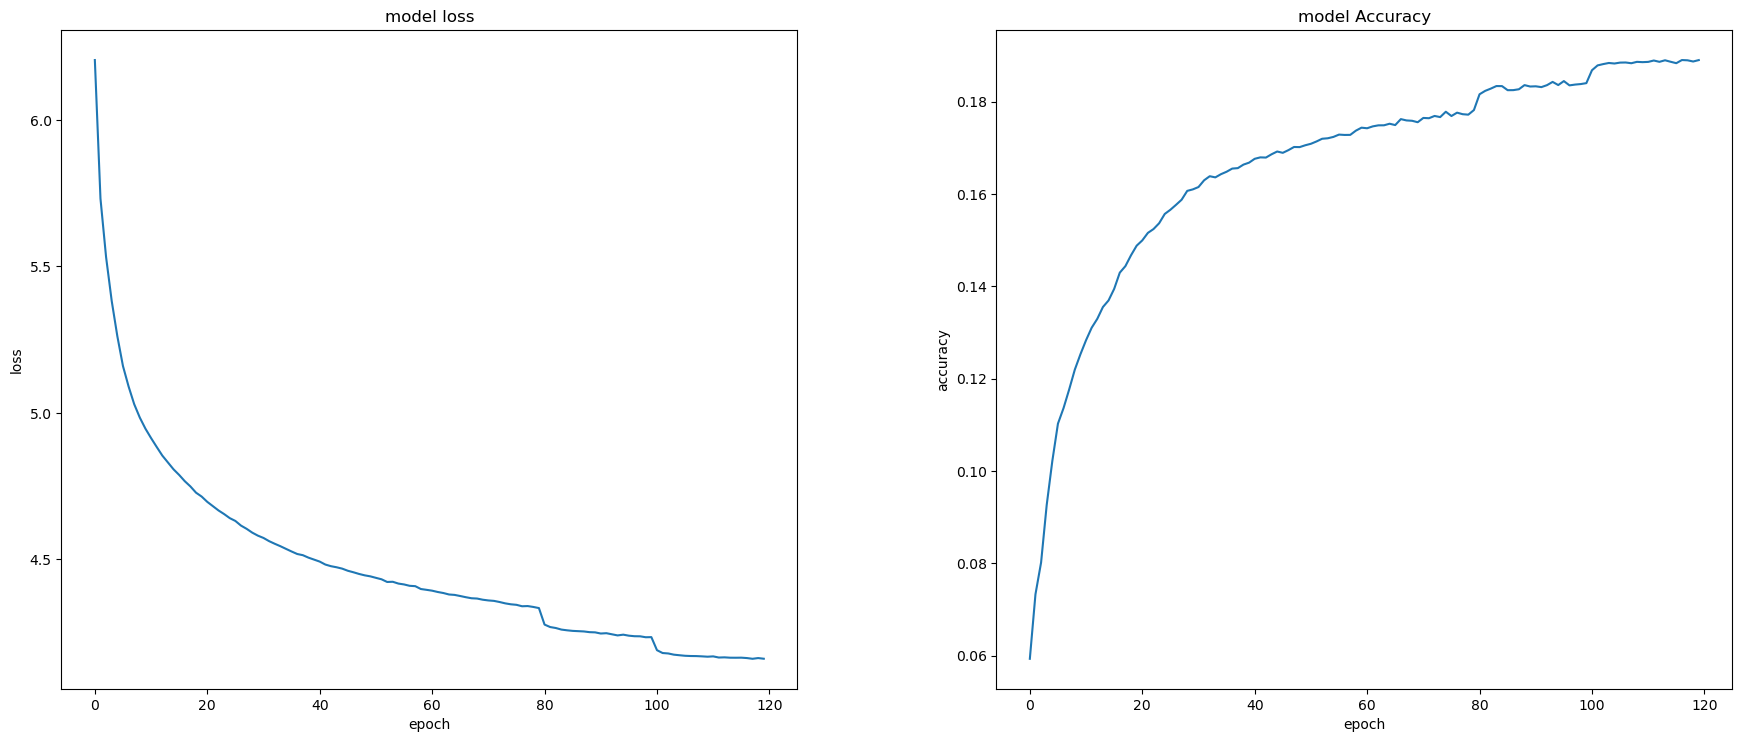

In [ ]:
#Here the history is of length 1 ,Bidirectional LSTM layer has 400 units and LSTM layer has 100 units.
#This means the encoded data x contains only one tokenized word and first layer which is bidirectional contains 400 neurons and 2nd layer which is a forward layer has 100 neurons and the model is iterated for 120 epochs to be trained.
lstm_model(2,200,100,120)

Data Encoded
Data_x [[1418    5   36]
 [   5   36   12]
 [  36   12  524]
 [  12  524  134]
 [ 524  134    4]]
Data_y [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Vocab_Size 2693
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 3, 3)              8079      
                                                                 
 bidirectional_4 (Bidirectio  (None, 3, 400)           326400    
 nal)                                                            
                                                                 
 lstm_9 (LSTM)               (None, 100)               200400    
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                          

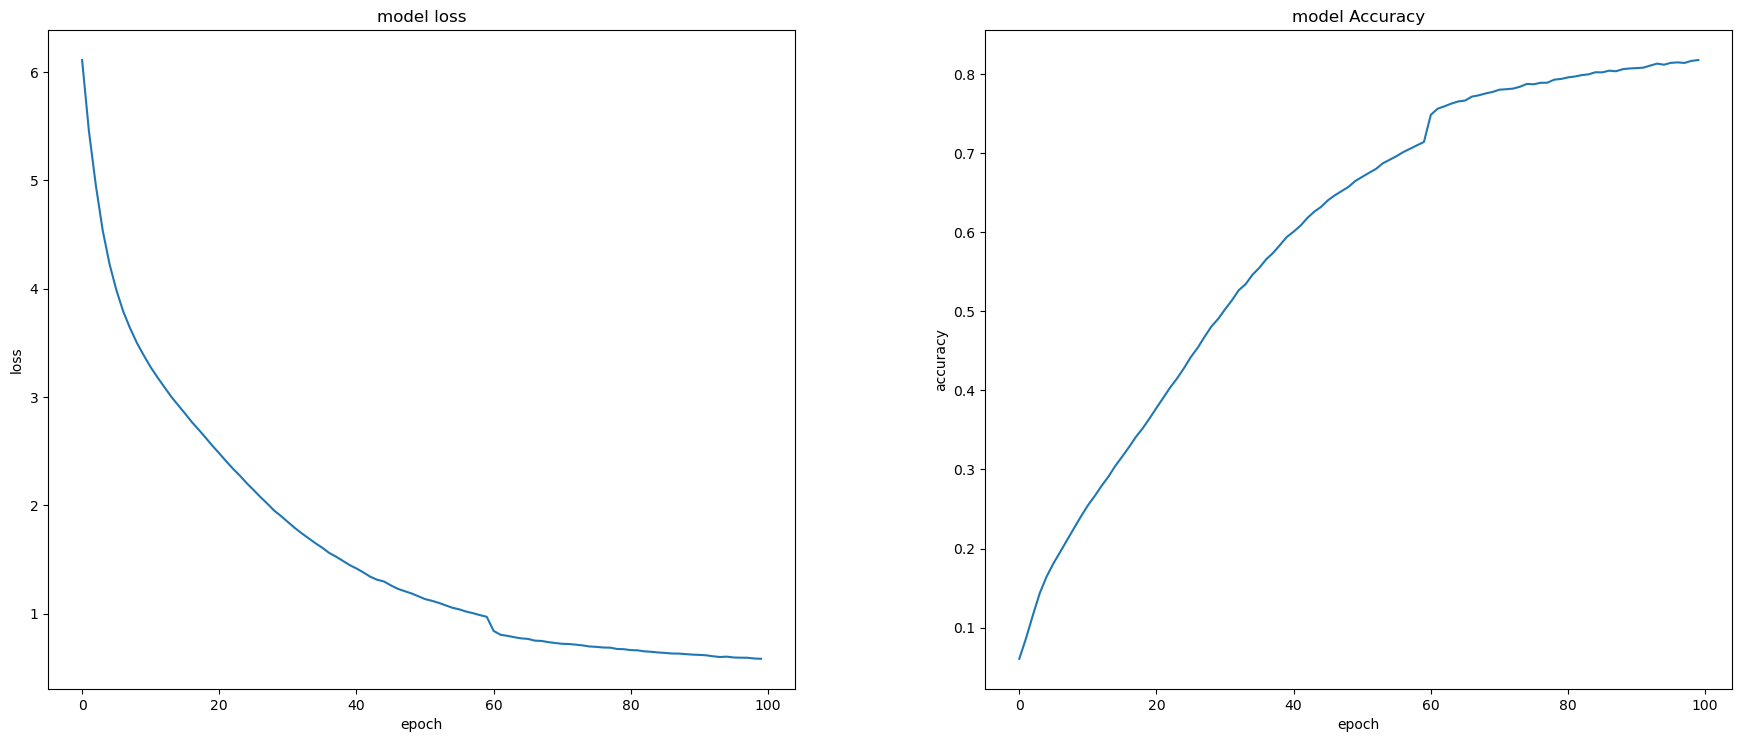

In [ ]:
#Here the history is of length 3 ,Bidirectional LSTM layer has 400 units and LSTM layer has 100 units and iterated for 100 epochs.
lstm_model(4,200,100,100)

Data Encoded
Data_x [[108  59  38 107 305]
 [ 59  38 107 305  81]
 [ 38 107 305  81 100]
 [107 305  81 100 183]
 [305  81 100 183 142]]
Data_y [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Vocab_Size 2693
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 5, 5)              13465     
                                                                 
 bidirectional_5 (Bidirectio  (None, 5, 128)           35840     
 nal)                                                            
                                                                 
 lstm_11 (LSTM)              (None, 32)                20608     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                 

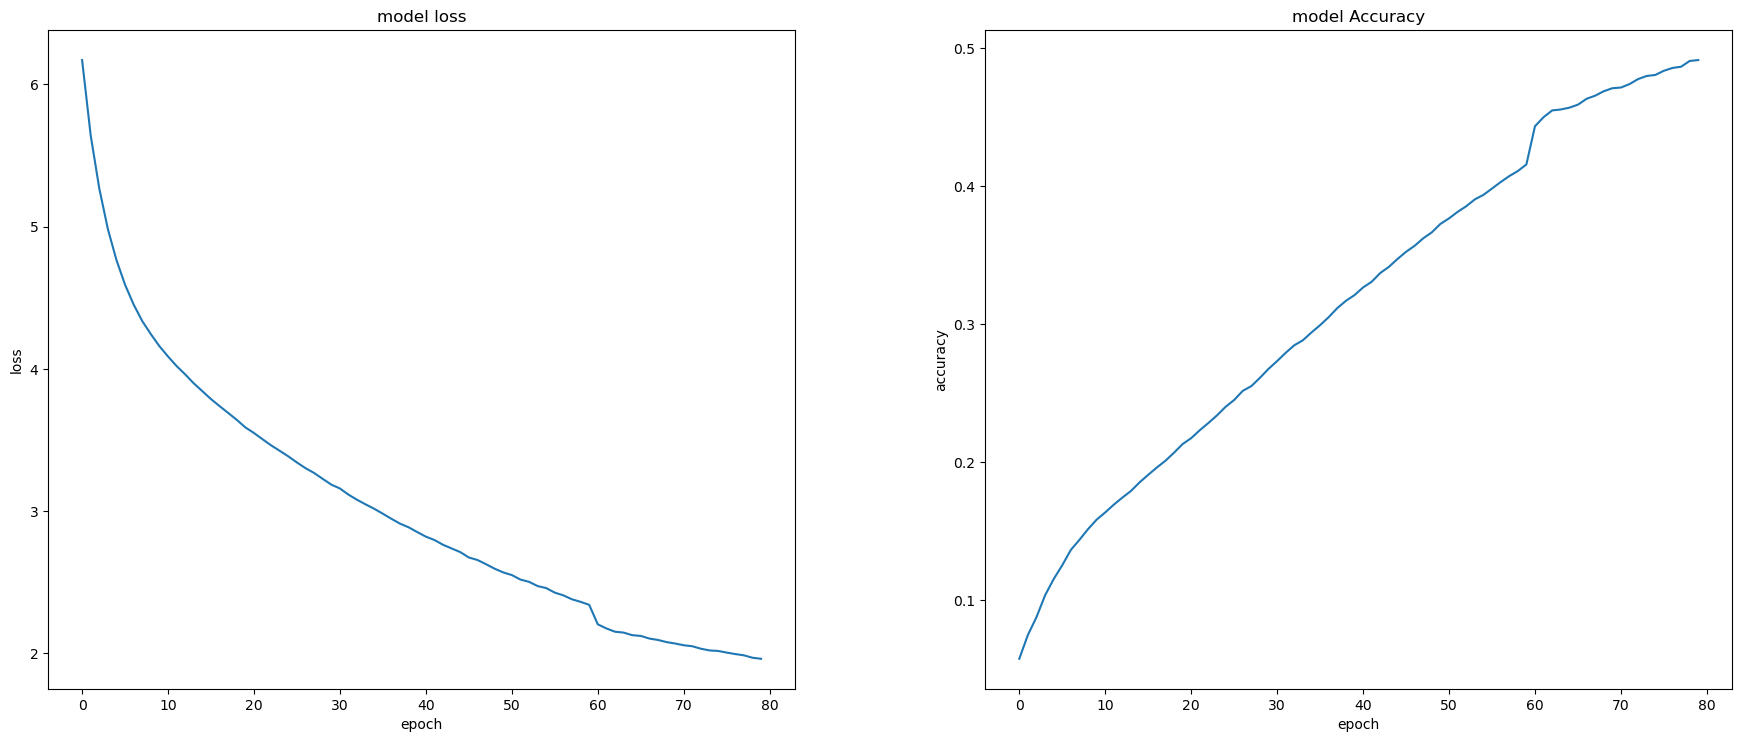

In [ ]:
#Here the history is of length 5 ,Bidirectional LSTM layer has 128 units and LSTM layer has 32 units
lstm_model(6,64,32,80)

As per the information obtained from the above three models which is been trained, we can see that the trained model which is built using
* seq(2) shows loss: 4.1599 - accuracy: 0.1890 for 120 epochs,
*  seq(4) shows loss: 0.5835 - accuracy: 0.8177 for 100 epochs,
* seq(6) shows loss: 1.9618 - accuracy: 0.4913 for 60 epochs.

#### Creating test data to test the models

In [ ]:
# PAD SEQUENCES
'''
start - random integer that indicates the starting index of tokens in the test data
temp_length - length of each line in the test corpus from which test data will be created
length - length of history + next word in the test data
'''
def create_testdata2(start,temp_length,length):
    seq=[]

    for i in range(temp_length,50000):
        words = cleaned_corpus[i-temp_length+start:i+start]
        line = ' '.join(words)
        seq.append(line)
    with open('len_tokens'+str(length)+'.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)


    sequences = tokenizer.texts_to_sequences(seq)
    sequences = pad_sequences(sequences, maxlen=length, truncating='pre')
    sequences=np.array(sequences)

    vocab=len(tokenizer.word_counts)+1
    print(vocab)
    data_x=sequences[:,:-1]
    data_y=sequences[:,-1]
    data_y = to_categorical(data_y, num_classes=vocab)
    del seq,sequences
    return data_x,data_y

# Calling trained models

file="lstm_len6.hdf5"
model_len6 = load_model(file)
model_len6.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

file="lstm_len4.hdf5"
model_len4 = load_model(file)
model_len4.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

file="lstm_len2.hdf5"
model_len2 = load_model(file)
model_len2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
# Setting the start and temp_length
start=random.randint(1, 1000)
temp_length=random.randint(1, 10)

len2_x,len2_y=create_testdata2(start,temp_length,2)
model_len2.evaluate(x=len2_x,y=len2_y)
del len2_x,len2_y

10000 tokens done
20000 tokens done
30000 tokens done
40000 tokens done
2693
1563/1563 [==============================] - 8s 3ms/step - loss: 81.3245 - accuracy: 0.0089


In [ ]:
len4_x,len4_y=create_testdata2(start,temp_length,4)
model_len4.evaluate(x=len4_x,y=len4_y)
del len4_x,len4_y

10000 tokens done
20000 tokens done
30000 tokens done
40000 tokens done
2693
1563/1563 [==============================] - 9s 5ms/step - loss: 29.6718 - accuracy: 4.6001e-04


In [ ]:
len6_x,len6_y=create_testdata2(start,temp_length,6)
model_len6.evaluate(x=len6_x,y=len6_y)
del len6_x,len6_y

10000 tokens done
20000 tokens done
30000 tokens done
40000 tokens done
2693
1563/1563 [==============================] - 5s 3ms/step - loss: 19.2631 - accuracy: 0.0060


#### As per the information obtained from the above three testing phase of the model, we can see the loss is very high and accuracy is also lower when compared to the training phase. So, the base model isn't fit to be used.

#### Predicting Next Word

In [ ]:
def extra_space(text):
    new_text= re.sub("\s+"," ",text)
    return new_text
def sp_charac(text):
    new_text=re.sub("[^0-9A-Za-z ]", "" , text)
    return new_text
def tokenize_text(text):
    new_text=word_tokenize(text)
    return new_text

def predict_next():
    with open('len_tokens6.pickle', 'rb') as handle:
        length_tokens_6 = pickle.load(handle)
    with open('len_tokens4.pickle', 'rb') as handle:
        length_tokens_4 = pickle.load(handle)
    with open('len_tokens2.pickle', 'rb') as handle:
        length_tokens_2 = pickle.load(handle)

    file="lstm_len6.hdf5"
    model_len6 = load_model(file)
    model_len6.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    file="lstm_len4.hdf5"
    model_len4 = load_model(file)
    model_len4.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    file="lstm_len2.hdf5"
    model_len2 = load_model(file)
    model_len2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    while(True):
        text=input()
        start= time.time()
        cleaned_text=extra_space(text)
        cleaned_text=sp_charac(cleaned_text)
        tokenized=tokenize_text(cleaned_text)
        line = ' '.join(tokenized)

        if len(tokenized)==1:

            encoded_text = length_tokens_2.texts_to_sequences([line])
            pad_encoded = pad_sequences(encoded_text, maxlen=1, truncating='pre')

            for i in (model_len2.predict(pad_encoded)[0]).argsort()[-3:][::-1]:
                pred_word = length_tokens_2.index_word[i]
                print("Next word suggestion:",pred_word)

        elif len(tokenized)<4:
            encoded_text = length_tokens_4.texts_to_sequences([line])
            pad_encoded = pad_sequences(encoded_text, maxlen=3, truncating='pre')

            for i in (model_len4.predict(pad_encoded)[0]).argsort()[-3:][::-1]:
                pred_word = length_tokens_4.index_word[i]
                print("Next word suggestion:",pred_word)

        else:
            encoded_text = length_tokens_6.texts_to_sequences([line])
            pad_encoded = pad_sequences(encoded_text, maxlen=5, truncating='pre')

            for i in (model_len6.predict(pad_encoded)[0]).argsort()[-3:][::-1]:
                pred_word = length_tokens_6.index_word[i]
                print("Next word suggestion:",pred_word)
        print('Time taken: ',time.time()-start)

In [ ]:
#predict_next()

 deep


1/1 [==============================] - 1s 676ms/step
Next word suggestion: neural
Next word suggestion: learning
Next word suggestion: networks
Time taken:  0.7100262641906738


 deep networks


1/1 [==============================] - 1s 605ms/step
Next word suggestion: can
Next word suggestion: is
Next word suggestion: that
Time taken:  0.6369426250457764


 deep networks can


1/1 [==============================] - 0s 16ms/step
Next word suggestion: efficiently
Next word suggestion: be
Next word suggestion: build
Time taken:  0.04338669776916504


 deep networks can efficiently


1/1 [==============================] - 1s 619ms/step
Next word suggestion: extract
Next word suggestion: find
Next word suggestion: study
Time taken:  0.6496553421020508


 deep networks can efficiently extract


1/1 [==============================] - 0s 15ms/step
Next word suggestion: the
Next word suggestion: a
Next word suggestion: to
Time taken:  0.05158495903015137


KeyboardInterrupt: Interrupted by user

## LSTM with Attention Model


In [ ]:
# Reading the cleaned tokens
with open("cleaned_text.txt", "rb") as fp:   # Unpickling
    cleaned_corpus = pickle.load(fp)
print(len(cleaned_corpus))

# Creating the sequences
def create_data(length):
    seq=[]
    start=random.randint(0, len(cleaned_corpus))
    for i in range(length,len(cleaned_corpus)):
        words = cleaned_corpus[i-length+start:i+start]
        line = ' '.join(words)
        seq.append(line)
    with open('length_seq_ATT'+str(length)+'.json', 'w') as fp:
        json.dump(seq, fp)
    del seq

#Sequence of length 2
create_data(2)

#Sequence of length 4
create_data(4)

#Sequence of length 6
create_data(6)

1107576


In [ ]:
# Encoding Data and splitting it into x and y
def encoding_data(length):
    with open('length_seq_ATT'+str(length)+'.json', 'r') as fp:
        seq=json.load( fp)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(seq[:100000])
    sequences = tokenizer.texts_to_sequences(seq[:100000])
    sequences=np.array(sequences)
    vocab=len(tokenizer.word_counts)+1
    data_x=sequences[:,:-1]
    data_y=sequences[:,-1]
    data_y = to_categorical(data_y, num_classes=vocab)
    words_to_index = tokenizer.word_index
    with open('len_tokens_ATT'+str(length)+'.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    del seq
    return data_x,data_y,vocab,words_to_index



In [ ]:
#Attention Model for classification
class attention(Layer):
    def init(self):
        super(attention,self).__init__()
    def build(self,input_shape):
        self.W=self.add_weight(name='att_weight',shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name='att_bias',shape=(input_shape[-2],1),initializer="zeros")
        super(attention, self).build(input_shape)
    def call(self,x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        return K.sum(output, axis=1)

In [ ]:
# Preparing the LSTM models
def lstm_model(length,unit1,n):
    # Calling the encoding function to get the data of specified length and the vocabulary
    data_x,data_y,v,wti=encoding_data(length)
    print("Data Encoded")
    print("Data_x",data_x[:5])
    print("Data_y",data_y[:5])
    print("Vocab_Size",v)

    # Preparing the model based on the inputs of unit1 ,unit2 and vocab values
    model = Sequential()
    model.add(Embedding(v, length-1, input_length=length-1))
    model.add(Bidirectional(LSTM(unit1, return_sequences=True)))
    model.add(attention())
    model.add(Dense(v, activation='softmax'))
    print(model.summary())
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    filepath="lstm_att_len"+str(length)+".hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

    callbacks_list = [checkpoint]

    history=model.fit(data_x, data_y,batch_size=128, epochs=n,callbacks=callbacks_list)

    del data_x,data_y,v,wti

    # Plotting the loss and accuracy achieved by the model in each epoch
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
    ax[0].plot(history.history['loss'])
    ax[1].plot(history.history['accuracy'])
    ax[0].set_title('model loss')
    ax[1].set_title('model Accuracy')
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].set_xlabel('epoch')
    fig.tight_layout(pad=10.0)
    plt.show()

Data Encoded
Data_x [[123]
 [302]
 [  4]
 [107]
 [142]]
Data_y [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Vocab_Size 2693
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 1, 1)              2693      
                                                                 
 bidirectional_6 (Bidirectio  (None, 1, 64)            8704      
 nal)                                                            
                                                                 
 attention (attention)       (None, 64)                65        
                                                                 
 dense_12 (Dense)            (None, 2693)              175045    
                                                                 
Total params: 186,507
Trainable params: 186,507

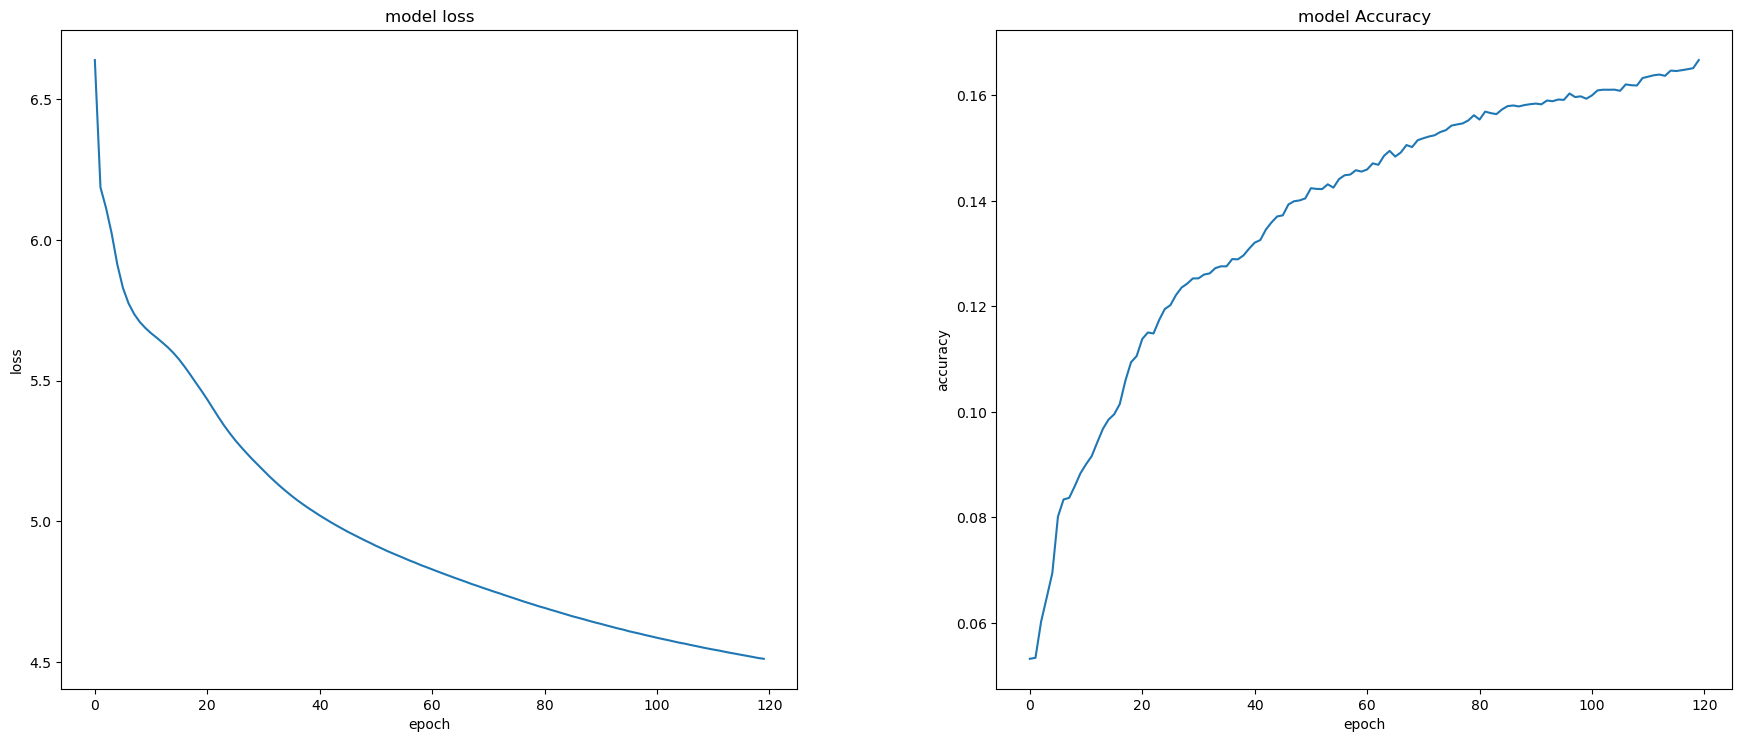

In [ ]:
#Here the history is of length 1, Bidirectional LSTM layer has 64 units and it is iterated for 120 epochs.
lstm_model(2,32,120)

Data Encoded
Data_x [[127 817 551]
 [817 551  15]
 [551  15 405]
 [ 15 405   5]
 [405   5 155]]
Data_y [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Vocab_Size 2693
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 3, 3)              8079      
                                                                 
 bidirectional_7 (Bidirectio  (None, 3, 128)           34816     
 nal)                                                            
                                                                 
 attention_1 (attention)     (None, 128)               131       
                                                                 
 dense_13 (Dense)            (None, 2693)              347397    
                                                                 
Total p

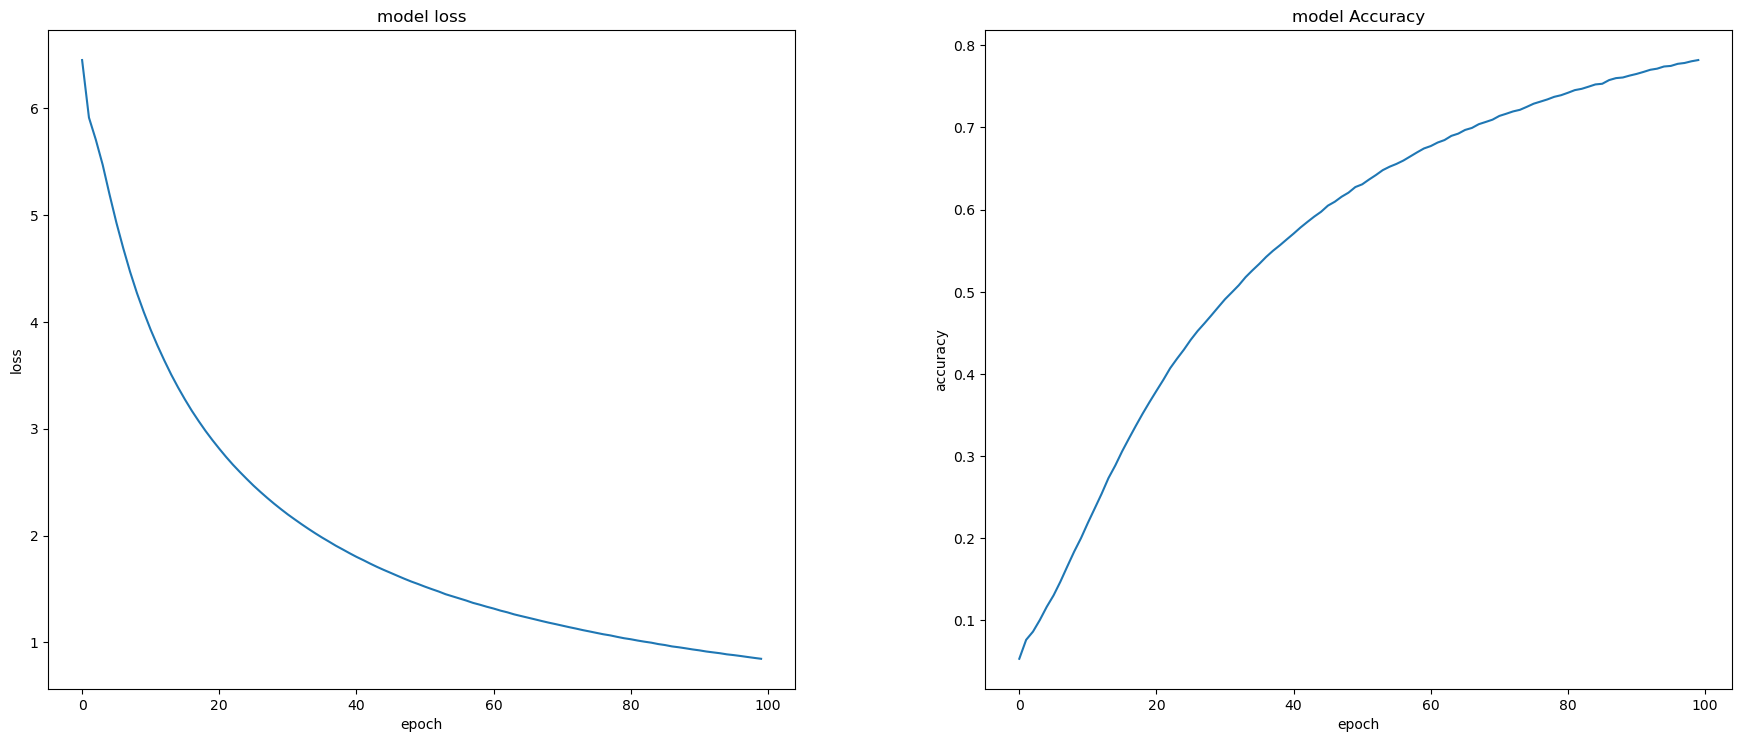

In [ ]:
#Here the history is of length 3 ,Bidirectional LSTM layer has 128 and it is iterated for 100 epoch.
lstm_model(4,64,100)

Data Encoded
Data_x [[ 76 815 734 314 442]
 [815 734 314 442  16]
 [734 314 442  16 277]
 [314 442  16 277  22]
 [442  16 277  22  28]]
Data_y [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Vocab_Size 2693
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 5, 5)              13465     
                                                                 
 bidirectional_8 (Bidirectio  (None, 5, 128)           35840     
 nal)                                                            
                                                                 
 attention_2 (attention)     (None, 128)               133       
                                                                 
 dense_14 (Dense)            (None, 2693)              347397    
                                 

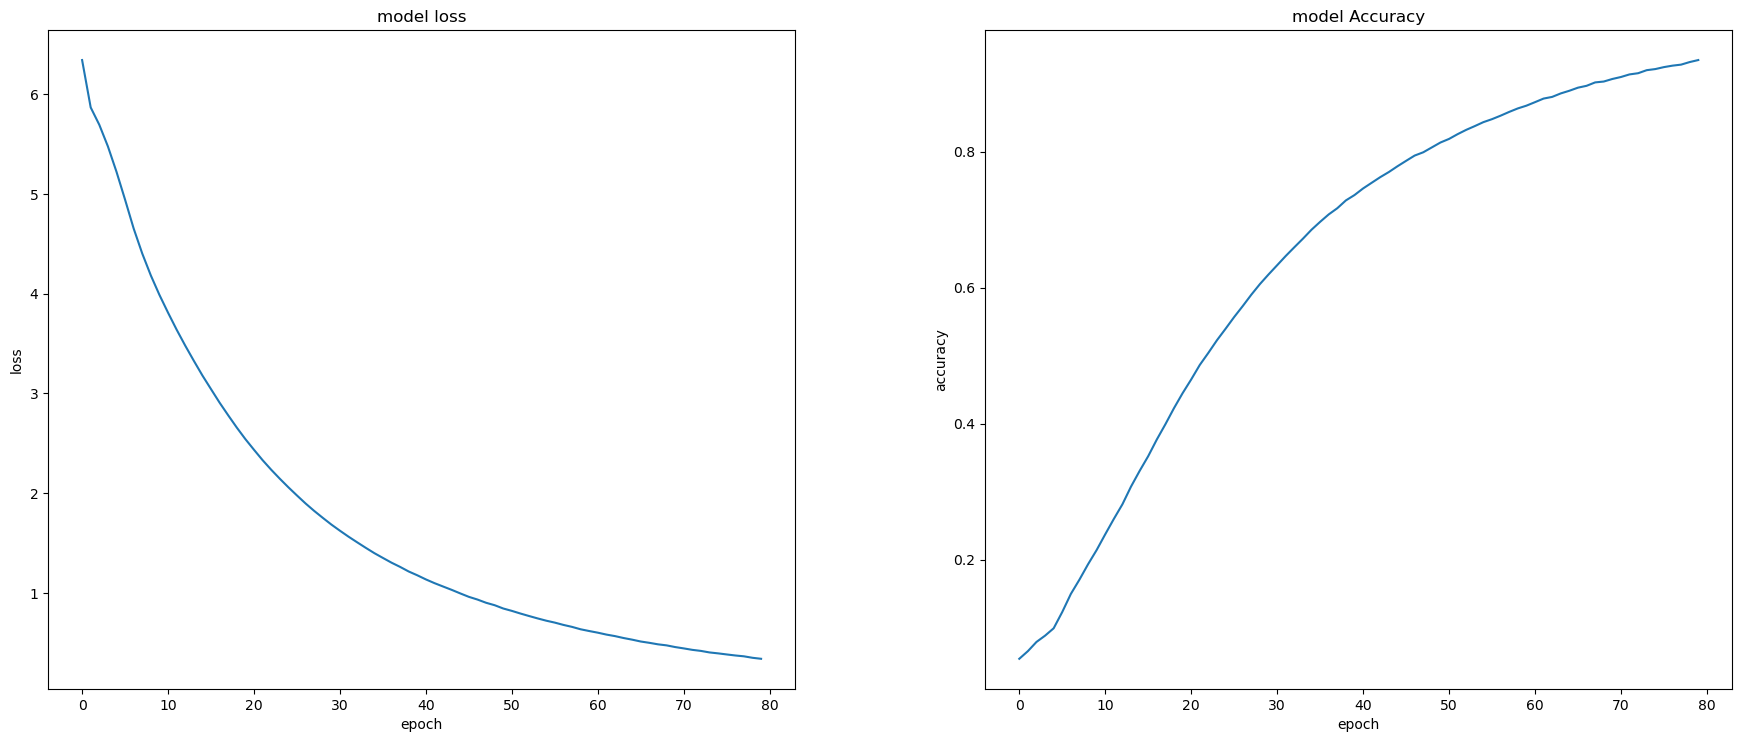

In [ ]:
#Here the history is of length 5 ,Bidirectional LSTM layer has 128 units and it is iterated for 80 epoch.
lstm_model(6,64,80)

#### As per the information obtained from the above three models which is been trained, we can see that the model which is built using
* seq(2) shows loss: 4.5114 - accuracy: 0.1667 for 120 epochs,
* seq(4) shows loss: 0.8467 - accuracy: 0.7820 for 100 epochs
* seq(6) shows loss: 0.3403 - accuracy: 0.9344 for 60 epochs.

#### Creating test data to test the models

In [ ]:
# PAD SEQUENCES
'''
start - random integer that indicates the starting index of tokens in the test data
temp_length - length of each line in the test corpus from which test data will be created
length - length of history + next word in the test data
'''
def create_testdata2(start,temp_length,length):
    seq=[]

    for i in range(temp_length,50000):
        words = cleaned_corpus[i-temp_length+start:i+start]
        line = ' '.join(words)
        seq.append(line)
    with open('len_tokens_ATT'+str(length)+'.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)


    sequences = tokenizer.texts_to_sequences(seq)
    sequences = pad_sequences(sequences, maxlen=length, truncating='pre')
    sequences=np.array(sequences)

    vocab=len(tokenizer.word_counts)+1
    print(vocab)
    data_x=sequences[:,:-1]
    data_y=sequences[:,-1]
    data_y = to_categorical(data_y, num_classes=vocab)
    del seq,sequences
    return data_x,data_y


# Calling trained models

file="lstm_att_len6.hdf5"
model_len6 = load_model(file, custom_objects={'attention': attention})
model_len6.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

file="lstm_att_len4.hdf5"
model_len4 = load_model(file, custom_objects={'attention': attention})
model_len4.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

file="lstm_att_len2.hdf5"
model_len2 = load_model(file , custom_objects={'attention': attention})
model_len2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [ ]:
# Setting the start and temp_length
start=random.randint(1, 1000)
temp_length=random.randint(7, 10)
print(start,temp_length)

len2_x,len2_y=create_testdata2(start,temp_length,2)
model_len2.evaluate(x=len2_x,y=len2_y)
del len2_x,len2_y

414 8
2693
1563/1563 [==============================] - 4s 2ms/step - loss: 4.4868 - accuracy: 0.1674


In [ ]:
len4_x,len4_y=create_testdata2(start,temp_length,4)
model_len4.evaluate(x=len4_x,y=len4_y)
del len4_x,len4_y

2693
1563/1563 [==============================] - 8s 4ms/step - loss: 0.8313 - accuracy: 0.7883


In [ ]:
len6_x,len6_y=create_testdata2(start,temp_length,6)
model_len6.evaluate(x=len6_x,y=len6_y)
del len6_x,len6_y

2693
1563/1563 [==============================] - 9s 5ms/step - loss: 0.3255 - accuracy: 0.9386


#### As per the information obtained from the above three testing phase of the models, we can see the loss is low and accuracy is similar to the training phase values too. There is a huge difference from the models which have attention layer into the Bi-LSTM models. So, this model is reliable for use.

#### Predicting Next Word

In [ ]:
class attention(Layer):
    def init(self):
        super(attention,self).__init__()
    def build(self,input_shape):
        self.W=self.add_weight(name='att_weight',shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name='att_bias',shape=(input_shape[-2],1),initializer="zeros")
        super(attention, self).build(input_shape)
    def call(self,x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        return K.sum(output, axis=1)

def extra_space(text):
    new_text= re.sub("\s+"," ",text)
    return new_text
def sp_charac(text):
    new_text=re.sub("[^0-9A-Za-z ]", "" , text)
    return new_text
def tokenize_text(text):
    new_text=word_tokenize(text)
    return new_text

def predict_next():
    with open('len_tokens_ATT6.pickle', 'rb') as handle:
        length_tokens_6 = pickle.load(handle)
    with open('len_tokens_ATT4.pickle', 'rb') as handle:
        length_tokens_4 = pickle.load(handle)
    with open('len_tokens_ATT2.pickle', 'rb') as handle:
        length_tokens_2 = pickle.load(handle)

    file="lstm_att_len6.hdf5"
    model_len7 = load_model(file ,custom_objects={'attention': attention})
    model_len7.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    file="lstm_att_len4.hdf5"
    model_len4 = load_model(file, custom_objects={'attention': attention})
    model_len4.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    file="lstm_att_len2.hdf5"
    model_len2 = load_model(file , custom_objects={'attention': attention})
    model_len2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    while(True):
        text=input()
        start= time.time()
        cleaned_text=extra_space(text)
        cleaned_text=sp_charac(cleaned_text)
        tokenized=tokenize_text(cleaned_text)

        line = ' '.join(tokenized)


        if len(tokenized)==1:

            encoded_text = length_tokens_2.texts_to_sequences([line])
            pad_encoded = pad_sequences(encoded_text, maxlen=1, truncating='pre')

            for i in (model_len2.predict(pad_encoded)[0]).argsort()[-3:][::-1]:


                pred_word = length_tokens_2.index_word[i]
                print("Next word suggestion:",pred_word)
        elif len(tokenized)<4:
            encoded_text = length_tokens_4.texts_to_sequences([line])
            pad_encoded = pad_sequences(encoded_text, maxlen=3, truncating='pre')

            for i in (model_len4.predict(pad_encoded)[0]).argsort()[-3:][::-1]:


                pred_word = length_tokens_4.index_word[i]
                print("Next word suggestion:",pred_word)
        else:
            encoded_text = length_tokens_6.texts_to_sequences([line])
            pad_encoded = pad_sequences(encoded_text, maxlen=5, truncating='pre')

            for i in (model_len6.predict(pad_encoded)[0]).argsort()[-3:][::-1]:


                pred_word = length_tokens_6.index_word[i]
                print("Next word suggestion:",pred_word)
        print('Time taken: ',time.time()-start)

In [ ]:
predict_next()

 deep networks can efficiently


1/1 [==============================] - 1s 607ms/step
Next word suggestion: extract
Next word suggestion: evaluate
Next word suggestion: fit
Time taken:  0.6470961570739746


 deep networks can efficiently extract


1/1 [==============================] - 0s 22ms/step
Next word suggestion: the
Next word suggestion: various
Next word suggestion: these
Time taken:  0.05646872520446777


 deep networks can efficiently extract the


1/1 [==============================] - 0s 26ms/step
Next word suggestion: intrinsic
Next word suggestion: fundamental
Next word suggestion: representations
Time taken:  0.06554579734802246


 The stochastic gradient model is used for


1/1 [==============================] - 0s 26ms/step
Next word suggestion: speech
Next word suggestion: deep
Next word suggestion: few
Time taken:  0.06242632865905762


 The stochastic gradient model is used for speech


1/1 [==============================] - 0s 24ms/step
Next word suggestion: recognition
Next word suggestion: memory
Next word suggestion: and
Time taken:  0.05678915977478027


 The stochastic gradient model is used for speech recognition


1/1 [==============================] - 0s 27ms/step
Next word suggestion: mechanism
Next word suggestion: task
Next word suggestion: works
Time taken:  0.06255769729614258


KeyboardInterrupt: Interrupted by user

## DEPLOYMENT from FLASK API

In [ ]:
import re
import pickle
import time
from nltk.tokenize import word_tokenize
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from flask import Flask, request, render_template

#Attention Model for classification
class attention(Layer):
    def init(self):
        super(attention,self).__init__()
    def build(self,input_shape):
        self.W=self.add_weight(name='att_weight',shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name='att_bias',shape=(input_shape[-2],1),initializer="zeros")
        super(attention, self).build(input_shape)
    def call(self,x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        return K.sum(output, axis=1)

def extra_space(text):
    new_text= re.sub("\s+"," ",text)
    return new_text

def sp_charac(text):
    new_text=re.sub("[^0-9A-Za-z ]", "" , text)
    return new_text

def tokenize_text(text):
    new_text=word_tokenize(text)
    return new_text


app = Flask(__name__)

with open('len_tokens_ATT6.pickle', 'rb') as handle:
    length_tokens_6 = pickle.load(handle)

with open('len_tokens_ATT4.pickle', 'rb') as handle:
    length_tokens_4 = pickle.load(handle)

with open('len_tokens_ATT2.pickle', 'rb') as handle:
    length_tokens_2 = pickle.load(handle)

file="lstm_att_len6.hdf5"
model_len6 = load_model(file ,custom_objects={'attention': attention})
model_len6.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

file="lstm_att_len4.hdf5"
model_len4 = load_model(file, custom_objects={'attention': attention})
model_len4.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

file="lstm_att_len2.hdf5"
model_len2 = load_model(file , custom_objects={'attention': attention})
model_len2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

@app.route('/')
def my_form():
    return render_template('my-form.html')

@app.route('/', methods=['POST'])
def predict_next():
    text = request.form['text']
    if not text:
        return render_template('my-form.html', error="Please enter a new word / sentence!")
    start= time.time()
    cleaned_text=extra_space(text)
    cleaned_text=sp_charac(cleaned_text)
    tokenized=tokenize_text(cleaned_text)
    line = ' '.join(tokenized)
    pred_words = []
    if len(tokenized)==1:
        encoded_text = length_tokens_2.texts_to_sequences([line])
        pad_encoded = pad_sequences(encoded_text, maxlen=1, truncating='pre')
        for i in (model_len2.predict(pad_encoded)[0]).argsort()[-3:][::-1]:
            pred_word = length_tokens_2.index_word[i]
            pred_words.append(text + " " + pred_word)
    elif len(tokenized) < 4:
        encoded_text = length_tokens_4.texts_to_sequences([line])
        pad_encoded = pad_sequences(encoded_text, maxlen=3, truncating='pre')
        for i in (model_len4.predict(pad_encoded)[0]).argsort()[-3:][::-1]:
            pred_word = length_tokens_4.index_word[i]
            pred_words.append(text + " " + pred_word)
    else:
        encoded_text = length_tokens_6.texts_to_sequences([line])
        pad_encoded = pad_sequences(encoded_text, maxlen=5, truncating='pre')
        for i in (model_len6.predict(pad_encoded)[0]).argsort()[-3:][::-1]:
            pred_word = length_tokens_6.index_word[i]
            pred_words.append(text + " " + pred_word)
    print('Time taken: ',time.time()-start)
    return render_template('my-form.html', pred_words=pred_words)

if __name__ == '__main__':
    app.run()

HTML Page and part of Deployment process was obtained from ChatGPT 3.4